# 교사 모델 학습하기

In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose, ToTensor
from torchvision.transforms import RandomHorizontalFlip, RandomCrop
from torchvision.transforms import Normalize
from torch.utils.data.dataloader import DataLoader
from torchvision.models.resnet import resnet34, resnet18

from torch.optim.adam import Adam

/home/restful3/anaconda3/envs/trading/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/restful3/anaconda3/envs/trading/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
transforms = Compose([
    RandomCrop((32, 32), padding=4),
    RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean=(0.4914, 0.822, 0.4465),
             std=(0.247, 0.243, 0.261))    
])

In [3]:
train_data = CIFAR10(root='/home/restful3/datasets/torch/',
                       train=True, download=True, transform=transforms)
test_data = CIFAR10(root='/home/restful3/datasets/torch/',
                       train=False, download=True, transform=transforms)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader = DataLoader(
    train_data,
    batch_size=32,
    shuffle=True
)
test_loader = DataLoader(
    test_data,
    batch_size=32,
    shuffle=False
)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
# Pretrained 를 사용하지 않는 경우
teacher = resnet34(pretrained=False, num_classes=10)
# # 모델을 사용할 디바이스로 이동
teacher.to(device)

/home/restful3/anaconda3/envs/trading/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/restful3/anaconda3/envs/trading/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# Pretrained 를 사용하는 경우
# teacher = resnet34(pretrained=False)
# # 새로운 클래스 개수
# num_classes = 10

# # 모델의 fc 레이어를 새로운 클래스 개수에 맞게 변경
# teacher.fc = nn.Linear(in_features=teacher.fc.in_features, out_features=num_classes)



# # 모델의 fc 레이어 파라미터만 학습 가능하도록 설정
# for name, param in teacher.named_parameters():
#     if name.startswith('fc'):
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

In [8]:
lr = 1e-5
optim = Adam(teacher.parameters(), lr=lr)

In [ ]:
for epoch in range(30):
    iterator = tqdm(train_loader)
    for data, label in iterator:
        data, label = data.to(device), label.to(device)
        optim.zero_grad()
        
        preds = teacher(data)
        loss = nn.CrossEntropyLoss()(preds, label)
        loss.backward()
        
        optim.step()
        
        iterator.set_description(f'epoch : {epoch+1}, loss : {loss.item()} ')
        
torch.save(teacher.state_dict(), './models/teacher.pth')        

epoch : 1, loss : 2.3148961067199707 :  15%|▏| 239/1563 [00:06<00:32, 40.80it/s]

In [9]:
teacher.load_state_dict(torch.load('./models/teacher.pth', map_location=device))

num_corr = 0

with torch.no_grad():
    for data, label in tqdm(test_loader):
        data, label = data.to(device), label.to(device)
        
        output = teacher(data)
        preds = output.data.max(1)[1]
        corr = preds.eq(label).sum().item()
        num_corr += corr
        
    print(f'Acc : {num_corr/len(test_data)}')

100%|█████████████████████████████████████████| 313/313 [00:05<00:00, 53.91it/s]

Acc : 0.6996


# GAN 생성자 정의하기

In [9]:
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, dims=256, channels=3):
        super(Generator, self).__init__()
        
        self.l1 = nn.Sequential(
            nn.Linear(dims, 128*8*8)
        )
        
        self.conv_blocks0 = nn.Sequential(
            nn.BatchNorm2d(128)
        )
        
        self.conv_blocks1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        
        self.conv_blocks2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.BatchNorm2d(channels, affine=False)
        )
        
    def forward(self, z):
        out = self.l1(z.view(z.shape[0], -1))
        out = out.view(out.shape[0], -1, 8, 8)
        
        out = self.conv_blocks0(out)
        out = nn.functional.interpolate(out, scale_factor=2)
        out = self.conv_blocks1(out)
        out = nn.functional.interpolate(out, scale_factor=2)
        out = self.conv_blocks2(out)        
        
        return out

# 학생 모델과 생성자 학습하기

In [10]:
from torch.optim.adam import Adam
from torch.optim.sgd import SGD

teacher = resnet34(pretrained=False, num_classes=10)
teacher.load_state_dict(torch.load('./models/teacher.pth', map_location=device))
teacher.to(device)
teacher.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
student = resnet18(pretrained=False, num_classes=10)
student.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
generator = Generator()
generator.to(device)

Generator(
  (l1): Sequential(
    (0): Linear(in_features=256, out_features=8192, bias=True)
  )
  (conv_blocks0): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_blocks1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv_blocks2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
)

In [13]:
G_optim = Adam(generator.parameters(), lr=1e-3)
S_optim = SGD(student.parameters(), lr=0.1, weight_decay=5e-4, momentum=0.9)

In [23]:
epoch_list = []
g_loss_list = []
s_loss_list = []
for epoch in tqdm(range(1000)):
    for i in range(5):
        noise = torch.randn(256, 256, 1, 1, device=device)
        S_optim.zero_grad()
        
        fake = generator(noise).detach()
        teacher_output = teacher(fake)
        student_output = student(fake)
        
        S_loss = nn.L1Loss()(student_output, teacher_output.detach())
        
#         if (epoch%10 == 0) and (i == 4):
#             print(f'epoch : {epoch +1}, S_loss : {S_loss.item()}')
        
        S_loss.backward()
        S_optim.step()
    
    noise = torch.randn(256, 256, 1, 1, device=device)
    G_optim.zero_grad()
    
    fake = generator(noise)
    
    teacher_output = teacher(fake)
    student_output = student(fake)

    G_loss = -1*nn.L1Loss()(student_output, teacher_output.detach())
    G_loss.backward()
    G_optim.step()    
    
    if epoch%10 == 0:
#         print(f'epoch : {epoch +1}, G_loss : {G_loss.item()}, S_loss : {S_loss.item()}')
        epoch_list.append(epoch)
        g_loss_list.append(G_loss.item())
        s_loss_list.append(S_loss.item())
    
torch.save(student.state_dict(), './models/student.pth')            

100%|███████████████████████████████████████| 1000/1000 [01:40<00:00,  9.96it/s]


<AxesSubplot:xlabel='epoch'>

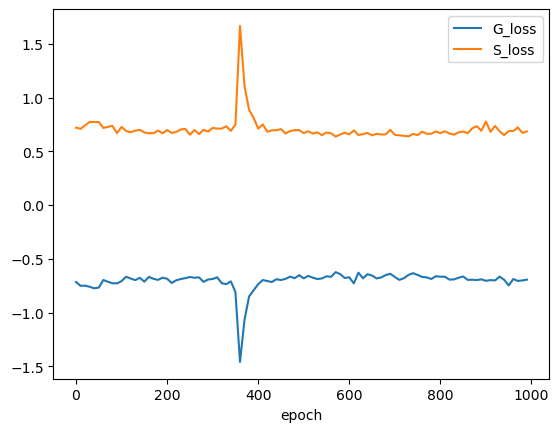

In [24]:
import pandas as pd

df = pd.DataFrame({'epoch': epoch_list, 'G_loss':g_loss_list, 'S_loss':s_loss_list})
df = df.set_index('epoch')
df.plot()

In [21]:
student.load_state_dict(torch.load('./models/student.pth', map_location=device))

num_corr = 0

with torch.no_grad():
    for data, label in tqdm(test_loader):
        data, label = data.to(device), label.to(device)
        
        output = student(data)
        preds = output.data.max(1)[1]
        corr = preds.eq(label).sum().item()
        num_corr += corr
        
    print(f'Acc : {num_corr/len(test_data)}')

100%|████████████████████████████████████████| 313/313 [00:02<00:00, 137.94it/s]

Acc : 0.1196
